In [1]:
#%% 
import warnings
warnings.filterwarnings('ignore')

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from preprocess import preprocess
from collections import Counter
import seaborn as sns
import pandas as pd

os.environ[ 'MPLCONFIGDIR' ] = './tmp/'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="0"

batch_size = 64 
lr = 0.01
epochs = 20
# torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class data(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x)
        self.y = torch.from_numpy(y)
        self.n_samples = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [3]:
class C_LSTM(nn.Module):
    def __init__(self, embedding_dim=300, n_filters=150, filter_size=3, bidirectional=True,
                 hidden_dim=150 , output_dim=5, dropout=0.5):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.conv = nn.Conv2d(in_channels=1, out_channels=150, kernel_size=(3,300))
        self.lstm = nn.LSTM(150, 150, bidirectional=False, dropout=0.5)
        self.projection = nn.Sequential(nn.Linear(150, 64), nn.ReLU(True), nn.Linear(64, 1))
        self.linear = nn.Linear(150, 5)
            
    def forward(self, x):  
        q = x.unsqueeze(1)
        r = F.relu(self.conv(q)).squeeze(3)
        x = r.permute(2, 0, 1)
        output, (_,_) = self.lstm(x)
        o = output.permute(1, 0, 2)
        eij = self.projection(o)
        alphas = F.softmax(eij.squeeze(-1), dim=1)
        weights = alphas.unsqueeze(-1)
        outputs = (o * weights).sum(dim=1)
        out = self.linear(outputs)
        final = F.softmax(out, dim=1)
        return final

In [4]:
train_path = "TrainData.csv"
test_path = 'TestData_Inputs.csv'

In [5]:
X,Y = preprocess(train_path)
X_test,y_test = preprocess(test_path)

#96754 word2vec
#8968 fasttext
#1107 glove
#593934 total
print(len(X_test), type(Y), len(Y))

735 <class 'list'> 1490


In [6]:
with open('glove.pickle', 'rb') as handle:
    glove_dict = pickle.load(handle)

Mean :  400.59060402684565
Median :  351.5
Max :  3438


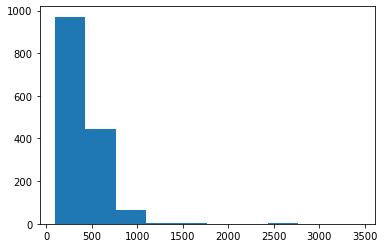

In [7]:
length = []
for sentence in X:
    length.append(len(sentence))
    
print('Mean : ', np.mean(length))
print('Median : ',np.median(length))
print('Max : ', max(length))

plt.hist(length)
plt.show() 

In [8]:
lesser = 0
greater= 0
word_limit = 800

for i in length:
    if i<=word_limit:
        lesser+=1
    else:
        greater+=1
print(f'Sentences greater than word limit {word_limit} are {greater}, lesser than word limit {word_limit} are {lesser}')

Sentences greater than word limit 800 are 53, lesser than word limit 800 are 1437


In [9]:
np.random.seed(5)
PAD = np.random.normal(loc=0.0, scale=0.25, size=(300))
categories = ['politics', 'tech', 'sport', 'business', 'entertainment']
train_X_vec = []
train_y_vec = []
for idx, para in enumerate(X):
    para_vec = []
    for i in range(word_limit):
        try:
            word = para[i]
            try:
                para_vec.append(glove_dict[word])
            except KeyError:
                continue
        except IndexError:
            para_vec.append(PAD)
    
    for i in range(word_limit-len(para_vec)):
        para_vec.append(PAD)
        
    train_X_vec.append(para_vec)
    train_y_vec.append(categories.index(Y[idx]))

train_X_vec = np.asarray(train_X_vec, dtype=np.float32)
train_y_vec = np.asarray(train_y_vec)
print(train_X_vec.shape, train_y_vec.shape)

(1490, 800, 300) (1490,)


In [10]:
X_test_vec = []
Y_test_vec = []
for idx, sample in enumerate(X_test):
    sentence = []
    for i in range(word_limit):
        try:
            word = sample[i]
            try:
                sentence.append(glove_dict[word])
            except KeyError:
                continue
        except IndexError:
            sentence.append(PAD)
    
    for i in range(word_limit-len(sentence)):
        sentence.append(PAD)
        
    X_test_vec.append(sentence)
    Y_test_vec.append(categories.index(y_test[idx]))
    
X_test_vec = np.asarray(X_test_vec, dtype=np.float32)
Y_test_vec = np.asarray(Y_test_vec)
print(X_test_vec.shape, Y_test_vec.shape)
index = np.arange(len(Y_test_vec))
for i in range(10): np.random.permutation(index)
Y_test_vec = Y_test_vec[index]

(735, 800, 300) (735,)


In [25]:
X_Train, X_val, Y_train, Y_val = train_test_split(train_X_vec, train_y_vec, test_size = 0.2, shuffle = True)

<AxesSubplot:ylabel='count'>

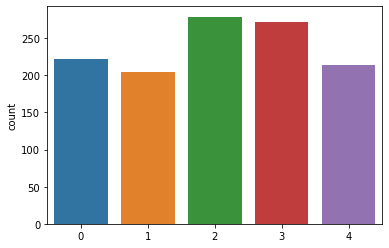

In [26]:
sns.countplot(Y_train)

<AxesSubplot:ylabel='count'>

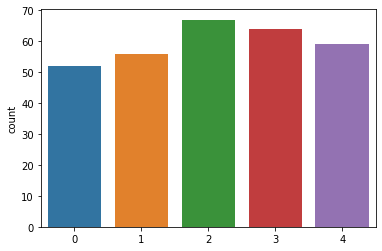

In [27]:
sns.countplot(Y_val)

In [28]:
train_dataset = data(X_Train, Y_train)
train_DataLoader = DataLoader(dataset=train_dataset, shuffle=True, batch_size = batch_size,)

valid_dataset = data(X_val, Y_val)
valid_DataLoader = DataLoader(dataset=valid_dataset, shuffle=True, batch_size = X_val.shape[0])

test_dataset = data(X_test_vec, Y_test_vec)
test_DataLoader = DataLoader(dataset=test_dataset, shuffle=False, batch_size = 735)
print(X_Train.shape, Y_train.shape)

(1192, 800, 300) (1192,)


In [29]:
def train_epoch(model,device,dataloader,loss,optimizer):
    train_loss = 0.0
    model.train()
    for (inputs, labels) in dataloader:

        inputs = inputs.to(device)
        labels = labels.to(device)
          
        output = model(inputs)
        l = loss(output,labels)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += l.item()

    return (train_loss)

In [30]:
def valid_epoch(model,device,dataloader,loss):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    with torch.no_grad():
        for (inputs, labels) in dataloader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)

            l=loss(output,labels)

        _, predictions = torch.max(output.data,1)
        score = f1_score(labels.cpu().data.numpy(), predictions.cpu().data.numpy(), average='micro')
        
        confusion_mtx = confusion_matrix(labels.cpu().data.numpy(), predictions.cpu().data.numpy(), normalize='true')
        df_cm = pd.DataFrame(confusion_mtx, index = categories, columns = categories)
        plt.figure(figsize = (20,7))
        sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
            

        return (l/len(labels)).cpu().detach().numpy(),score

In [31]:
model = C_LSTM().to(device)
loss = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [61]:
acc_list = []
loss_list = []
for epoch in range(epochs):
    epochs_loss = 0
    t0 = datetime.now()
    
    epochs_loss = train_epoch(model,device,train_DataLoader,loss,optimizer)
    
    l,score = valid_epoch(model,device,valid_DataLoader,loss)
    
    print(f'time: {datetime.now() - t0} epoch={epoch+1}/{epochs}, train loss={epochs_loss/len(X_Train):.6f}, val loss {l:.6f}, f: {score:.6f}')
    loss_list.append((epochs_loss/len(X_Train)))
    acc_list.append(score)
    



time: 0:00:01.786491 epoch=1/20, train loss=0.023505, val loss 0.004487, f: 0.546980
time: 0:00:01.768832 epoch=2/20, train loss=0.018221, val loss 0.003678, f: 0.848993
time: 0:00:01.761226 epoch=3/20, train loss=0.016028, val loss 0.003465, f: 0.865772
time: 0:00:01.765043 epoch=4/20, train loss=0.015413, val loss 0.003208, f: 0.953020
time: 0:00:01.779152 epoch=5/20, train loss=0.014943, val loss 0.003218, f: 0.946309
time: 0:00:01.760495 epoch=6/20, train loss=0.014984, val loss 0.003171, f: 0.959732
time: 0:00:01.771934 epoch=7/20, train loss=0.014655, val loss 0.003099, f: 0.986577
time: 0:00:01.767998 epoch=8/20, train loss=0.014622, val loss 0.003128, f: 0.973154
time: 0:00:01.759222 epoch=9/20, train loss=0.014542, val loss 0.003085, f: 0.986577
time: 0:00:01.769696 epoch=10/20, train loss=0.014467, val loss 0.003097, f: 0.979866
time: 0:00:01.769538 epoch=11/20, train loss=0.014449, val loss 0.003075, f: 0.989933
time: 0:00:01.767016 epoch=12/20, train loss=0.014487, val loss

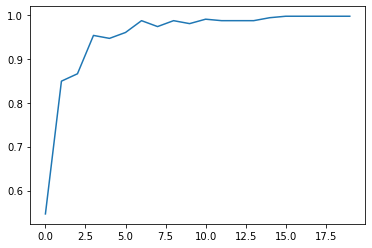

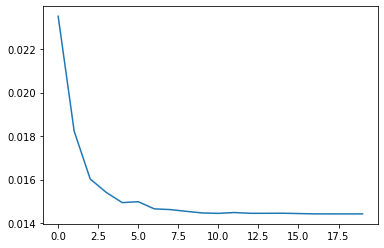

In [64]:
plt.plot(acc_list)
plt.show()
plt.plot(loss_list)
plt.show()

In [32]:
FILE = "saved_model/model3.pth"
# torch.save(model.state_dict(), FILE)

loaded_model = C_LSTM()
loaded_model.load_state_dict(torch.load(FILE))
loaded_model = loaded_model.to(device)
loaded_model.eval()

C_LSTM(
  (conv): Conv2d(1, 150, kernel_size=(3, 300), stride=(1, 1))
  (lstm): LSTM(150, 150, dropout=0.5)
  (projection): Sequential(
    (0): Linear(in_features=150, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (linear): Linear(in_features=150, out_features=5, bias=True)
)

Valid Loss 0.003047904698178172, Valid Score 0.9966442953020134
Test Loss 0.0012379365507513285, Test Score 0.9945578231292517


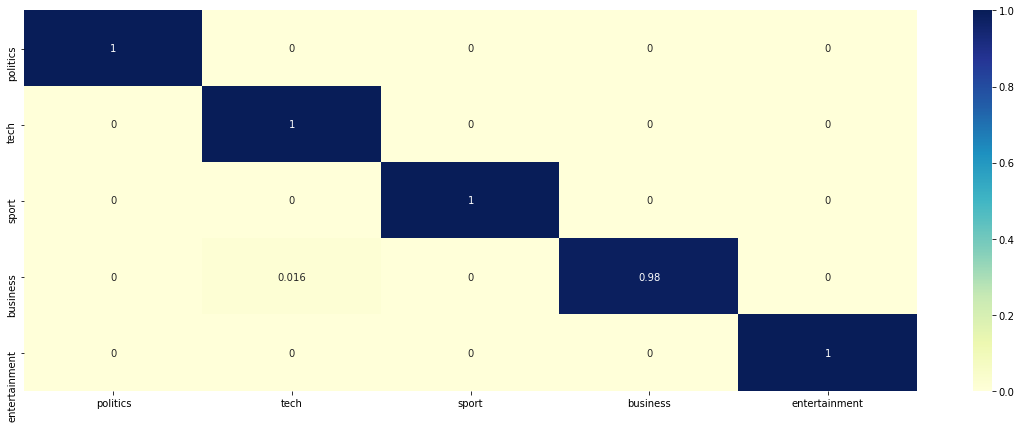

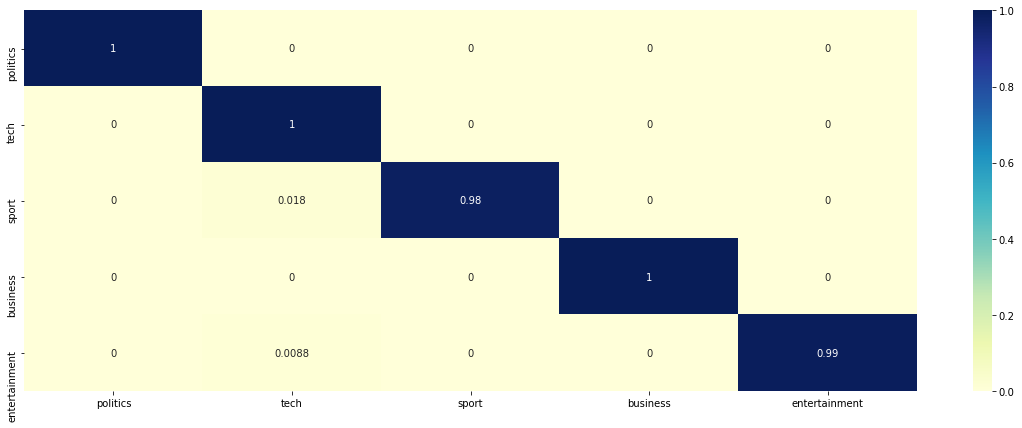

In [33]:
l, score = valid_epoch(loaded_model,device,valid_DataLoader,loss)
l_test, score_test = valid_epoch(loaded_model,device,test_DataLoader,loss)
print(f'Valid Loss {l}, Valid Score {score}')
print(f'Test Loss {l_test}, Test Score {score_test}')